# Imports

In [126]:
import os

from pandas.core.interchange.dataframe_protocol import DataFrame

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import numpy as np
from coreforecast.rolling import rolling_mean
from mlforecast.lag_transforms import RollingMean
from sklearn.metrics import mean_squared_error
import pandas as pd
from utilsforecast.plotting import plot_series
import numpy as np
import pandas as pd
import seaborn as sns
from coreforecast.lag_transforms import ExpandingMean
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from utilsforecast.plotting import plot_series
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression
import re


# Data Loading & Preprocessing

In [128]:
# Set the paths
data_path = "data/"

# Load CSVs
train = pd.read_csv(data_path + "train.csv", parse_dates=["date"])
calendar = pd.read_csv(data_path + "calendar_events.csv", parse_dates=["date"])
submission = pd.read_csv(data_path + "forecast_submission.csv")

In [129]:
def preprocess(df, calendar, first_timestep = 0):
    df = df.dropna()

    # Rename columns
    df = df.rename(columns={'store_name': 'unique_id', 'date': 'ds', 'revenue': 'y'})

    # Interpolate the zero-values (xmas)
    if 'y' in df.columns:
        df.loc[df['y'] == 0, 'y'] = np.nan
        df['y'] = df.groupby('unique_id')['y'].transform(lambda s: s.interpolate(method='linear'))

    # Timestep columns
    df = df.sort_values('ds')
    date_to_timestep = {date: i + first_timestep for i, date in enumerate(sorted(df['ds'].unique()))}
    df['timestep'] = df['ds'].map(date_to_timestep)

    # Merge with calendar events
    df = df.merge(calendar.rename(columns={'date': 'ds'}), on='ds', how='left')
    df['event'] = df['event'].fillna('None')

    # Get all known event types (including 'None')
    all_events = calendar['event'].dropna().unique().tolist()
    all_events.append('None')

    # Convert to categorical with fixed categories
    df['event'] = pd.Categorical(df['event'], categories=all_events)

    # One-hot encode
    df = pd.get_dummies(df, columns=['event'], prefix='event')

    # Sanitize column names
    df.columns = [clean_column(col) for col in df.columns]

    return df


def clean_column(name):
    return re.sub(r'\W+', '_', name)


def plot_df(df, count = 4):
    store_counts = df['unique_id'].value_counts()
    top_stores = store_counts[store_counts.index != 'All Stores'].head(count).index.tolist()

    # Plot revenue over time for top 4 stores
    fig, axs = plt.subplots(len(top_stores), 1, figsize=(12, 10), sharex=True)

    for i, store in enumerate(top_stores):
        sns.lineplot(data=df[df['unique_id'] == store], x='ds', y='y', ax=axs[i])
        axs[i].set_title(f'Store: {store}')
        axs[i].set_ylabel('Revenue')

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()


def plot_forecasts(df_actual, df_forecast, models, store_ids=None, history_days=60):
    """
    Plots actual vs forecasted revenue for selected stores.

    Parameters:
    - df_actual: DataFrame with actuals (`ds`, `y`, `unique_id`)
    - df_forecast: DataFrame with forecast (`ds`, `y_pred`, `unique_id`)
    - store_ids: list of store names to plot
    - history_days: number of days of actual data to show
    """
    if store_ids is None:
        store_ids = df_forecast['unique_id'].unique()[:3]  # default to first 3 stores

    fig, axs = plt.subplots(len(store_ids), 1, figsize=(12, 4 * len(store_ids)), sharex=True)

    if len(store_ids) == 1:
        axs = [axs]

    for i, store_id in enumerate(store_ids):
        ax = axs[i]
        actual = df_actual[df_actual['unique_id'] == store_id].sort_values('ds')
        forecast = df_forecast[df_forecast['unique_id'] == store_id].sort_values('ds')

        ax.plot(actual['ds'].iloc[-history_days:], actual['y'].iloc[-history_days:], label='Actual', linewidth=2)

        for model in models:
            ax.plot(forecast['ds'], forecast[model], label=model, linestyle='--', marker='o')

        ax.set_title(f'Forecast vs Actual for {store_id}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


def split_train_test(df, h):
    last_dates = df.groupby('unique_id')['ds'].max().reset_index()
    cutoff_dates = last_dates.copy()
    cutoff_dates['cutoff'] = cutoff_dates['ds'] - pd.Timedelta(days=h)

    df = df.merge(cutoff_dates[['unique_id', 'cutoff']], on='unique_id')
    train_df = df[df['ds'] <= df['cutoff']].drop(columns='cutoff')
    test_df = df[df['ds'] > df['cutoff']].drop(columns='cutoff')
    return train_df, test_df


def calc_rmse(df_actual, df_forecast):
    merged = df_actual.merge(df_forecast, on=['unique_id', 'ds'], how='left')
    rmse = {}
    for model in df_forecast.drop(columns=['unique_id', 'ds']).columns:
        rmse[model] = np.sqrt(mean_squared_error(merged['y'], merged[model]))
        print(f"{model}: {rmse[model]:.2f}")

    return rmse

In [130]:
h = 14  # number of days to predict

df = preprocess(train, calendar)
train_df, test_df = split_train_test(df, h=h)

# ML Forecast

In [157]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from mlforecast import MLForecast
from mlforecast.core import TimeSeries
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


# Define exogenous features (event columns)
exog_vars = [col for col in df.columns if col.startswith('event_')]
test_vars = ['unique_id', 'ds'] + exog_vars
train_vars = ['y'] + test_vars

# Create TimeSeries object

# Define ML models
models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    CatBoostRegressor(verbose=0),
    HistGradientBoostingRegressor()
]

# Initialize MLForecast
mlf = MLForecast(
    models=models,
    freq='D',
    lags=[1, 7, 14],
    date_features=['dayofweek', 'month', 'is_month_end'],
    num_threads=4
)

# Fit the model
mlf.fit(train_df[train_vars],
        static_features=[],
        prediction_intervals=PredictionIntervals(n_windows=10, h=h))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 16918, number of used features: 37
[LightGBM] [Info] Start training from score 42185.456047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 18458, number of used features: 37
[LightGBM] [Info] Start training from score 43141.626496


MLForecast(models=[LGBMRegressor, XGBRegressor, CatBoostRegressor, HistGradientBoostingRegressor], freq=D, lag_features=['lag1', 'lag7', 'lag14'], date_features=['dayofweek', 'month', 'is_month_end'], num_threads=4)

In [158]:
# Predict using the full feature set
mlf_forecast = mlf.predict(h=h, X_df=test_df[test_vars])

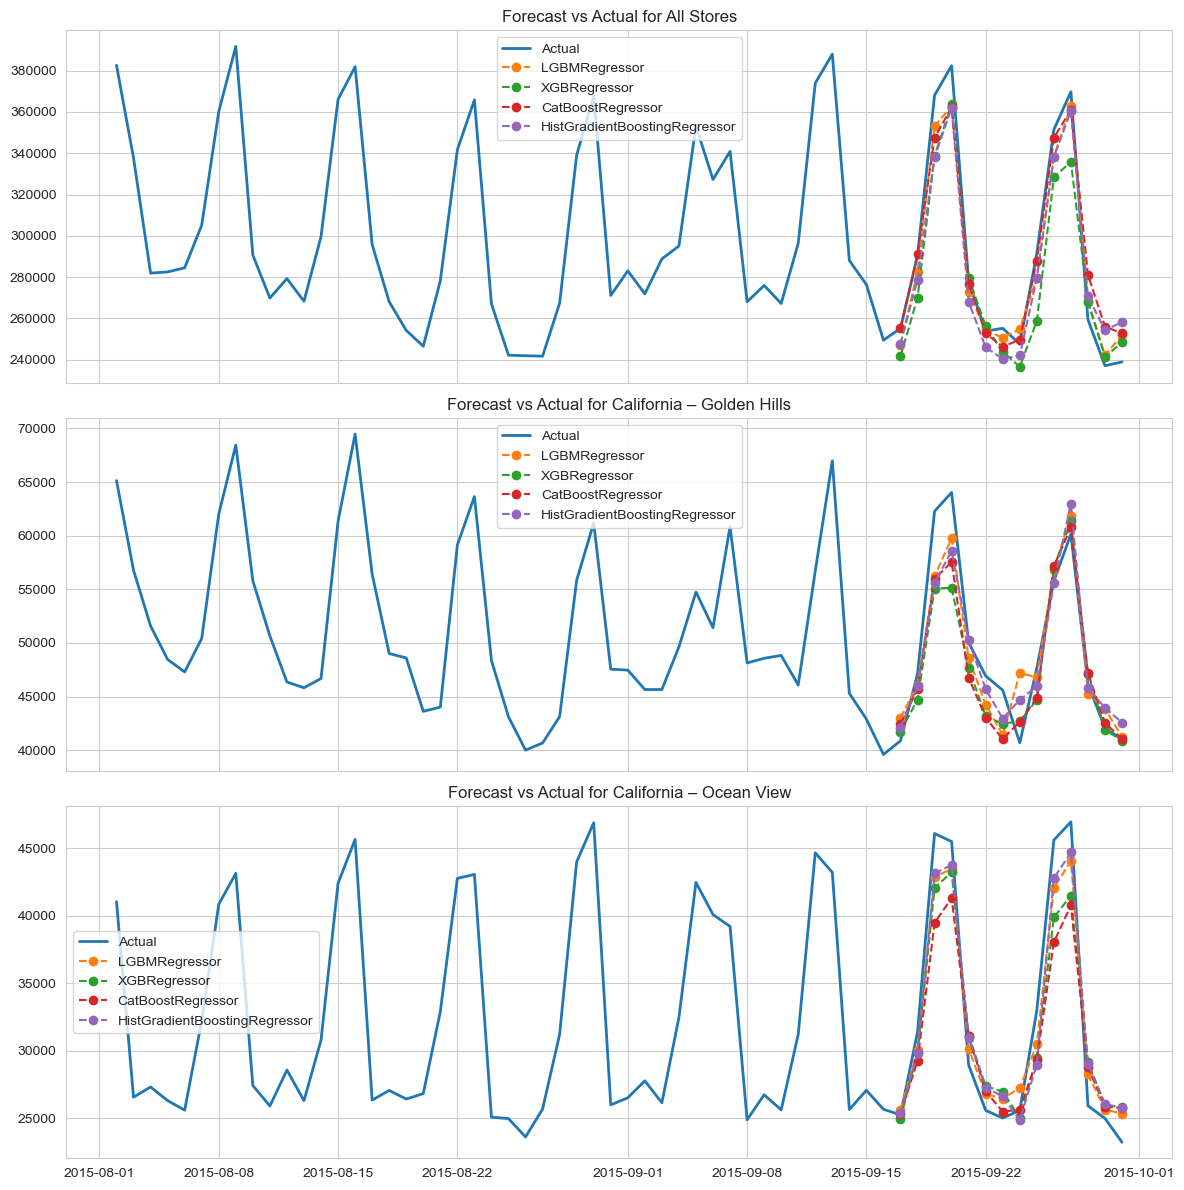

In [159]:
plot_forecasts(df, mlf_forecast, mlf.models)  # customize stores

In [135]:
mlf_rmse = calc_rmse(test_df, mlf_forecast)

LGBMRegressor: 4223.72
CatBoostRegressor: 4675.68


# Neural Forecast

In [136]:
from neuralforecast.models import NHITS  # or RNN, TCN, NBEATS, etc.
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.models import RNN
from neuralforecast.models import LSTM
from neuralforecast.models import TCN


# Define the model
models = [
    NHITS(input_size=4 * h,  # e.g. 4 times the horizon
          h=h,
          max_steps=1000,
          scaler_type='standard',
          val_check_steps=100),
    # NBEATS(input_size=4*h,
    #        h=h,
    #        max_steps=1000),
    # RNN(input_size=4*h, h=h, max_steps=1000),
    # LSTM(input_size=4*h, h=h, max_steps=1000),
    # TCN(input_size=4*h, h=h, max_steps=1000)
]

# Initialize forecast object
nf = NeuralForecast(models=models, freq='D')

Seed set to 1


In [137]:
# Fit the model
# nf.fit(train_df[train_vars])
# nf_forecast = nf.predict()
# plot_forecasts(df, nf_forecast)
# nf_rmse = calc_rmse(test_df, nf_forecast)

# Hierarchical Forecast

In [138]:
store_ids = df['unique_id'].unique()
store_ids[store_ids != 'All Stores']


array(['Texas – Lone Star Mall', 'Texas – Alamo Heights',
       'California – Redwood Center', 'Wisconsin – Lakeview Plaza',
       'California – Ocean View', 'California – Sunset Plaza',
       'California – Golden Hills', 'Wisconsin – Maple Grove',
       'Texas – Riverwalk Market', 'Wisconsin – Badger Crossing'],
      dtype=object)

# Test

In [139]:
store_id_map = df[['store_id', 'unique_id']].drop_duplicates()

def preprocess_submission(df, calendar, train_df):
    submission_df = df.copy()
    submission_df[['store_id', 'ds']] = submission_df['id'].str.split('_', expand=True)
    submission_df['store_id'] = submission_df['store_id'].astype(int)
    submission_df['ds'] = pd.to_datetime(submission_df['ds'])
    submission_df = submission_df.merge(store_id_map, on='store_id', how='left')
    submission_df = preprocess(submission_df, calendar, max(train_df['timestep']) + 1)

    return submission_df


def predict_recursive(nf: NeuralForecast, future: DataFrame):
    future = submission_df.copy()
    history = df.copy()
    vars_ext = train_vars + ['timestep']

    h = nf.h
    start = min(future['timestep'])
    end = max(future['timestep'])
    preds = []

    for i in range(start, end, h):
        pred = nf.predict(history)
        pred['y'] = pred[nf._get_model_names()].mean(axis=1)
        preds.append(pred)
        pred = pred.merge(future, how='left', on=['unique_id', 'ds'])[vars_ext]
        history = pd.concat([history, pred], ignore_index=True)[train_vars]

    predictions = pd.concat(preds, ignore_index=True)
    results = future.merge(predictions, how='left', on=['unique_id', 'ds'])
    results = results.drop(columns=['prediction'])

    return results


In [140]:
submission_df = preprocess_submission(submission, calendar, df)
submission_df

,id,prediction,store_id,ds,unique_id,timestep,event_SuperBowl,event_ValentinesDay,event_PresidentsDay,event_LentStart,...,event_Chanukah_End,event_NewYear,event_OrthodoxChristmas,event_MartinLutherKingDay,event_Easter,event_OrthodoxEaster,event_OrthodoxEaster_Cinco_De_Mayo,event_Easter_OrthodoxEaster,event_NBAFinalsEnd_Father_s_day,event_None
0,0_20151001,0,0,2015-10-01,All Stores,1706,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,6_20151001,0,6,2015-10-01,Texas – Riverwalk Market,1706,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,5_20151001,0,5,2015-10-01,Texas – Lone Star Mall,1706,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2_20151001,0,2,2015-10-01,California – Ocean View,1706,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,9_20151001,0,9,2015-10-01,Wisconsin – Lakeview Plaza,1706,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,1_20151231,0,1,2015-12-31,California – Sunset Plaza,1797,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1008,8_20151231,0,8,2015-12-31,Wisconsin – Maple Grove,1797,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1009,0_20151231,0,0,2015-12-31,All Stores,1797,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1010,6_20151231,0,6,2015-12-31,Texas – Riverwalk Market,1797,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [165]:
mlf.fit(df[train_vars],
        static_features=[],
        prediction_intervals=PredictionIntervals(n_windows=10, h=h))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 17072, number of used features: 37
[LightGBM] [Info] Start training from score 42291.962401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 18612, number of used features: 37
[LightGBM] [Info] Start training from score 43222.939866


MLForecast(models=[LGBMRegressor, XGBRegressor, CatBoostRegressor, HistGradientBoostingRegressor], freq=D, lag_features=['lag1', 'lag7', 'lag14'], date_features=['dayofweek', 'month', 'is_month_end'], num_threads=4)

In [142]:
nf.fit(df[train_vars])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.085    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


In [166]:
mlf_forecast = mlf.predict(h=len(submission_df['ds'].unique()), X_df=submission_df[test_vars])
nf_forecast = predict_recursive(nf, submission_df)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [167]:
mlf.models

{'LGBMRegressor': LGBMRegressor(),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'CatBoostRegressor': <catboost.core.CatBoostRegressor at 0x3000a42c0>,
 'HistGradientBoostingRegressor': HistGradientBoostingRegressor()}

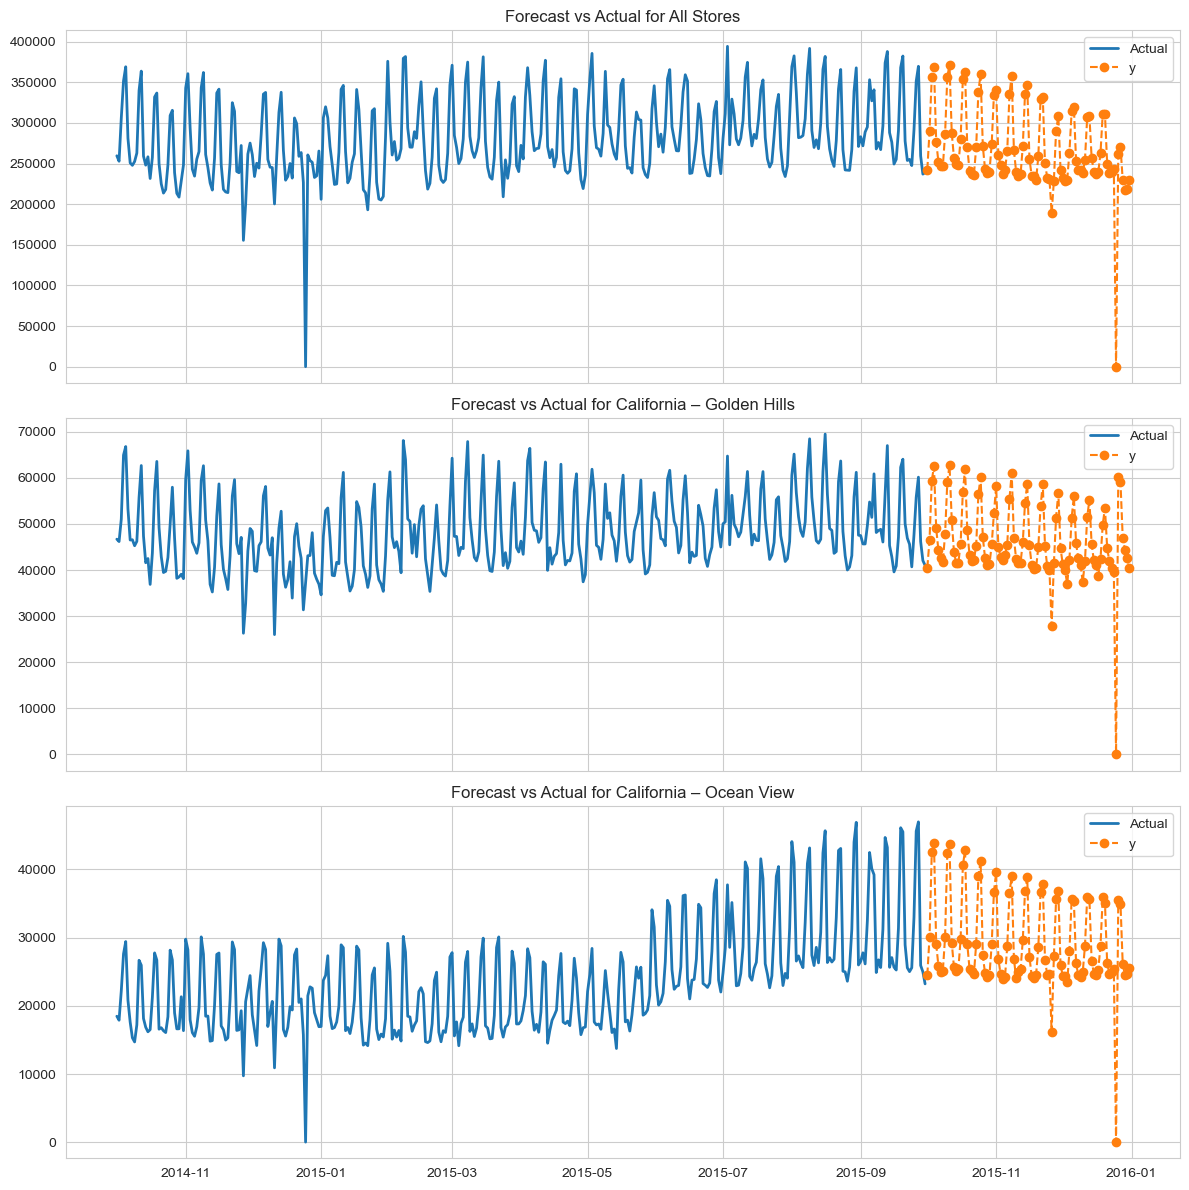

In [174]:
ensemble_forecast = mlf_forecast.merge(nf_forecast, how='left', on=['unique_id', 'ds'])
ensemble_forecast['y'] = ensemble_forecast[['CatBoostRegressor', 'NHITS', 'LGBMRegressor']].mean(axis=1)
ensemble_forecast.loc[(ensemble_forecast['ds'].dt.month == 12) & (ensemble_forecast['ds'].dt.day == 25), 'y'] = 0
plot_forecasts(df, ensemble_forecast, models=['y'], history_days=365)

In [175]:
submission_result = ensemble_forecast.copy()
submission_result['prediction'] = submission_result['y']
submission_result = submission_result[['id', 'prediction']]
submission_result.to_csv('submission.csv', index=False)

KeyError: 'prediction'

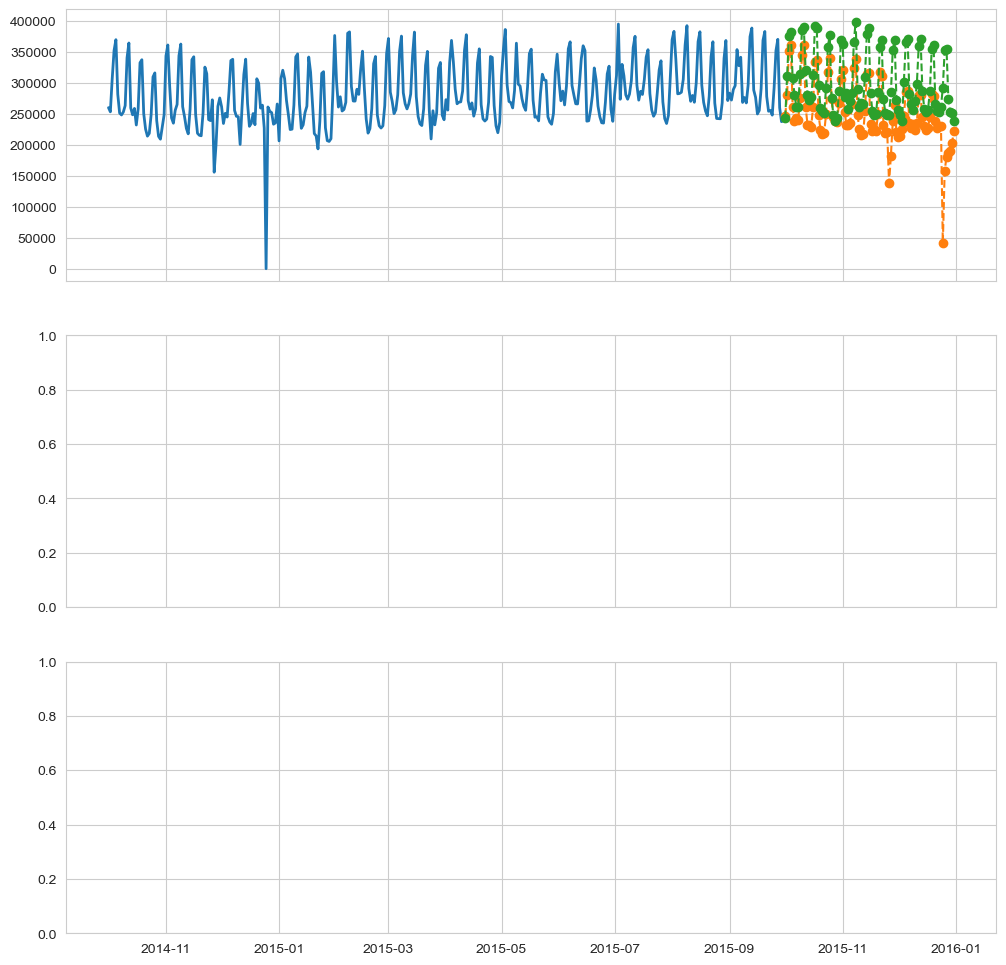

In [146]:
ensemble_forecast

,unique_id,ds,LGBMRegressor,CatBoostRegressor,id,store_id,timestep,event_SuperBowl,event_ValentinesDay,event_PresidentsDay,...,event_MartinLutherKingDay,event_Easter,event_OrthodoxEaster,event_OrthodoxEaster_Cinco_De_Mayo,event_Easter_OrthodoxEaster,event_NBAFinalsEnd_Father_s_day,event_None,NHITS,y,prediction
0,All Stores,2015-10-01,238545.9960935024,246504.04015702638,0_20151001,0,1706,False,False,False,...,False,False,False,False,False,False,True,242662.34,242662.34,NaN
1,All Stores,2015-10-02,279069.3594842812,280730.74621703406,0_20151002,0,1707,False,False,False,...,False,False,False,False,False,False,True,310210.34,310210.34,NaN
2,All Stores,2015-10-03,341255.6830066274,351711.51984708145,0_20151003,0,1708,False,False,False,...,False,False,False,False,False,False,True,375181.2,375181.2,NaN
3,All Stores,2015-10-04,364053.114651586,361219.68292917905,0_20151004,0,1709,False,False,False,...,False,False,False,False,False,False,True,382110.44,382110.44,NaN
4,All Stores,2015-10-05,263108.21804041264,261282.20150822884,0_20151005,0,1710,False,False,False,...,False,False,False,False,False,False,True,306845.16,306845.16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,Wisconsin – Maple Grove,2015-12-27,30773.76505888588,25654.377398140023,8_20151227,8,1793,False,False,False,...,False,False,False,False,False,False,True,29639.316,29639.316,NaN
1008,Wisconsin – Maple Grove,2015-12-28,24184.910351301005,22573.15078395745,8_20151228,8,1794,False,False,False,...,False,False,False,False,False,False,True,22507.803,22507.803,NaN
1009,Wisconsin – Maple Grove,2015-12-29,23157.8956964801,22956.89223141627,8_20151229,8,1795,False,False,False,...,False,False,False,False,False,False,True,21929.967,21929.967,NaN
1010,Wisconsin – Maple Grove,2015-12-30,23524.04992241755,24042.157832543955,8_20151230,8,1796,False,False,False,...,False,False,False,False,False,False,True,21910.855,21910.855,NaN
